In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
from tensorflow import keras
import tensorflow as tf
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import CategoricalScore

In [2]:
###Import of files

merged_df = pd.read_csv("detections_testing.csv", sep=",")
merged_df['date'] = pd.to_datetime(merged_df['date'], format="%Y-%m-%d %H:%M:%S")

In [3]:
### Building of vectors (input of CNN models)

out = []
rfid_year_list = pd.DataFrame()
out3 = []
for start_year in range(1998, 2022):
    start_date = datetime.datetime(year=start_year-1, month=9, day=30)
    end_date = start_date + timedelta(days=487)
    dRange = pd.date_range(start=start_date, end=end_date, freq="12H")
    # perform the grid search on time/rfid values
    values = merged_df[merged_df["year"] == start_year].groupby([pd.Grouper(key="date", freq="12H"), "rfid"])["antenna"].last().unstack().reindex(dRange).fillna(method="ffill").fillna(False).astype(int).values
    values_detect_number = merged_df[merged_df["year"] == start_year].groupby([pd.Grouper(key="date", freq="12H"), "rfid"])["antenna"].size().unstack().reindex(dRange).fillna(value=0).astype(int).values
    rfid_year = merged_df[merged_df["year"] == start_year][["rfid","year"]]
    # look for the corresponding breeding labels for this season
    out.extend(values.T)
    out3.extend(values_detect_number.T)
    if not rfid_year.empty:
        rfid_year_list = pd.concat([rfid_year_list, pd.DataFrame(rfid_year.drop_duplicates())])
        
final_value = [[0] for x in range(len(out))]
val = [[0,0] for x in range(975)]
for i in range(len(out)):
    for j in range(975):
        val[j] = [out[i][j],out3[i][j]]
    final_value[i]= np.array(val)
    
### Smaller vectors for determination of the sex    
final_value_425 = [i[0:425] for i in final_value]

In [4]:
###Import of models

model_NB_B = keras.models.load_model("models/model_determination_B_NB")
model_S_F = keras.models.load_model('models/model_determination_S_F')
model_M_F = keras.models.load_model('models/model_determination_M_F')
model_date_males = keras.models.load_model('models/determination_date_M')
model_date_females = keras.models.load_model('models/determination_date_F')

In [5]:
### Predictions with the models

prediction_NB_B = np.argmax(model_NB_B.predict(np.array(final_value)), axis=-1)
prediction_S_F = np.argmax(model_S_F.predict(np.array(final_value)), axis=-1)
prediction_M_F = model_M_F.predict(np.array(final_value_425))

data = pd.DataFrame({'rfid': rfid_year_list["rfid"], 'year': rfid_year_list["year"], 'pred_NB_B': prediction_NB_B, 'pred_S_F': prediction_S_F})
data.reset_index(inplace=True, drop=True)

data['pred_NB_B'] = data['pred_NB_B'].replace(0, "NB")
data['pred_NB_B'] = data['pred_NB_B'].replace(1, "B")

data['pred_S_F'] = data['pred_S_F'].replace(0, "F")
data['pred_S_F'] = data['pred_S_F'].replace(1, "S")

data_MF = pd.DataFrame(prediction_M_F, columns=["F", "M"])
data = data.merge(data_MF, left_index=True, right_index=True)

### lifetime sex determination
data_temp_B = data.loc[data["pred_NB_B"] == "B"]
sex_list = data.groupby('rfid').mean()[['F', 'M']]
sex_list['pred_M_F'] = sex_list.idxmax(axis=1)
sex_list = sex_list.drop(columns=['F', 'M'])
data = data.drop(columns=['F', 'M'])
data = data.merge(sex_list, on='rfid', how='left')
data['pred_M_F'] = data['pred_M_F'].fillna('I')

2009
Male : 47 0.9946602 2008-11-22 12:00:00


Text(0.5, 1.0, 'Certainty map giving most probable breeding date according to RFID detections for a female')

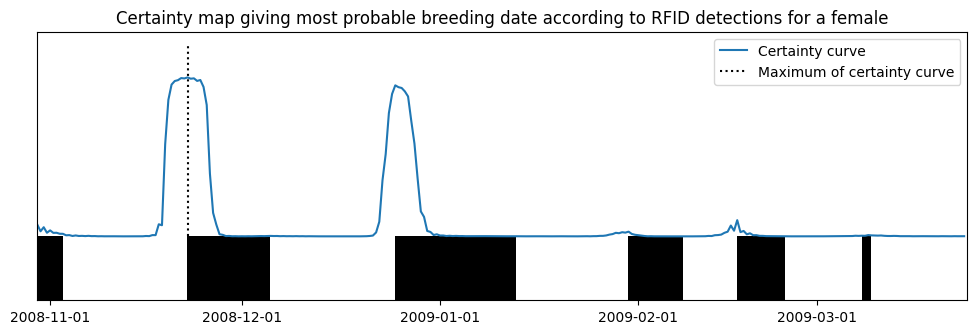

In [6]:
### Plot of the certainty map to determine the breeding date of a male
rfid = 'R 0000 0000000046627082'
year = 2009

ind = data.loc[(data["rfid"] == rfid) & (data["year"] == year)].index

vector_loc = np.array(out)[ind][0]
vector_detect = np.array(out3)[ind][0]
vector_compiled = [[0] for x in range(60,351)]
for i in range(60,351): 
    value_temp = vector_loc[i-60:i+150]
    value_temp_detect = vector_detect[i-60:i+150]
    vector_compiled[i-60]= list(zip(value_temp, value_temp_detect))  

temp_cert_sex_date = model_date_females.predict(np.array(vector_compiled))
    
M=[]
for i in temp_cert_sex_date:
     M.append(i[0])
start_date = datetime.datetime(year=year-1, month=10, day=30)
end_date = start_date + timedelta(days=145)
dRange = pd.date_range(start=start_date, end=end_date, freq="12H")
print(year)
print("Male :", np.argmax(M), M[np.argmax(M)], dRange[np.argmax(M)])

x=np.array(out)[ind][0][60:351]

fig, ax = plt.subplots(figsize = (12,6))
ax.imshow([x]*20,cmap='binary',interpolation='none', extent=[0, 291, -20, 0])
xlab = [4,64,126,188,244] 
ax.set_xticks(xlab)
ax.set_xticklabels([dRange.date[i] for i in xlab])
ax.axes.get_yaxis().set_visible(False)
plt.plot([x*50 for x in M], label='Certainty curve')
plt.vlines(np.argmax(M), ymin=0, ymax=60 , ls=':', colors='black', label = 'Maximum of certainty curve')
plt.legend()
plt.title('Certainty map giving most probable breeding date according to RFID detections for a female')

2011
Male : 38 0.99947387 2010-11-18 00:00:00


Text(0.5, 1.0, 'Certainty map giving most probable breeding date according to RFID detections for a male')

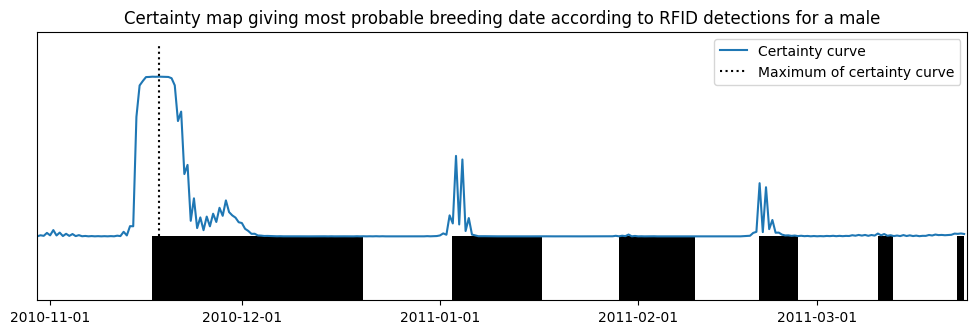

In [7]:
### Plot of the certainty map to determine the breeding date of a female

rfid = 'R 0000 0000000072520688'
year = 2011

ind = data.loc[(data["rfid"] == rfid) & (data["year"] == year)].index

vector_loc = np.array(out)[ind][0]
vector_detect = np.array(out3)[ind][0]
vector_compiled = [[0] for x in range(60,351)]
for i in range(60,351): 
    value_temp = vector_loc[i-60:i+150]
    value_temp_detect = vector_detect[i-60:i+150]
    vector_compiled[i-60]= list(zip(value_temp, value_temp_detect))  

temp_cert_sex_date = model_date_males.predict(np.array(vector_compiled))
    
M=[]
for i in temp_cert_sex_date:
     M.append(i[0])
start_date = datetime.datetime(year=year-1, month=10, day=30)
end_date = start_date + timedelta(days=145)
dRange = pd.date_range(start=start_date, end=end_date, freq="12H")
print(year)
print("Male :", np.argmax(M), M[np.argmax(M)], dRange[np.argmax(M)])

x=np.array(out)[ind][0][60:351]

fig, ax = plt.subplots(figsize = (12,6))
ax.imshow([x]*20,cmap='binary',interpolation='none', extent=[0, 291, -20, 0])
xlab = [4,64,126,188,244] 
ax.set_xticks(xlab)
ax.set_xticklabels([dRange.date[i] for i in xlab])
ax.axes.get_yaxis().set_visible(False)
plt.plot([x*50 for x in M], label='Certainty curve')
plt.vlines(np.argmax(M), ymin=0, ymax=60 , ls=':', colors='black', label = 'Maximum of certainty curve')
plt.legend()
plt.title('Certainty map giving most probable breeding date according to RFID detections for a male')

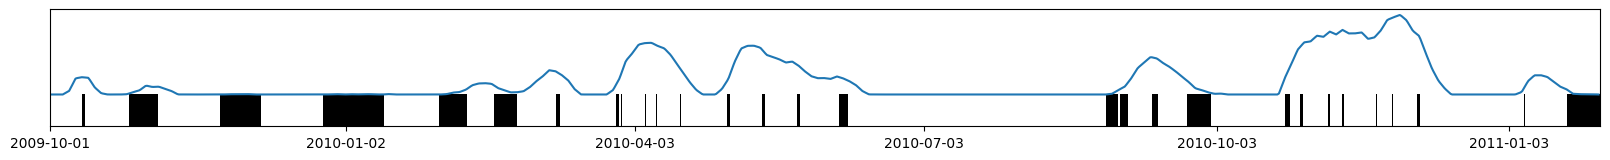

In [8]:
## Example of activation map visualization for successful vs failing breeding
replace2linear = ReplaceToLinear()

###Example for a succesful breeding
rfid = 'R 0000 0000000046627082'
year = 2009
index_rfid_year = data.loc[(data["rfid"] == rfid) & (data["year"] == year)].index[0]

gradcam_S_F = Gradcam(model_S_F,
                  model_modifier=replace2linear,
                  clone=True)

vector = final_value[index_rfid_year]
val = tf.expand_dims(np.array(vector).astype(np.float32), axis=0)
score = CategoricalScore([1])
gradcam_map_S_F = gradcam_S_F(score, val, penultimate_layer=-1)

x=[]
for i in(vector):
    x.append(i[0])
start_date = datetime.datetime(year=year, month=10, day=1)
end_date = start_date + timedelta(days=487)
dRange = pd.date_range(start=start_date, end=end_date, freq="12H")

fig, ax = plt.subplots(figsize = (20,10))
ax.imshow([x]*20,cmap='binary',interpolation='none', extent=[0, 975, -20, 0])
xlab = [0,186,368,550,734,918] 
ax.set_xticks(xlab)
ax.set_xticklabels([dRange.date[i] for i in xlab])
ax.axes.get_yaxis().set_visible(False)
ax.plot(gradcam_map_S_F[0]*50)
# fig.savefig('cyclemap_success.png', dpi = 300)

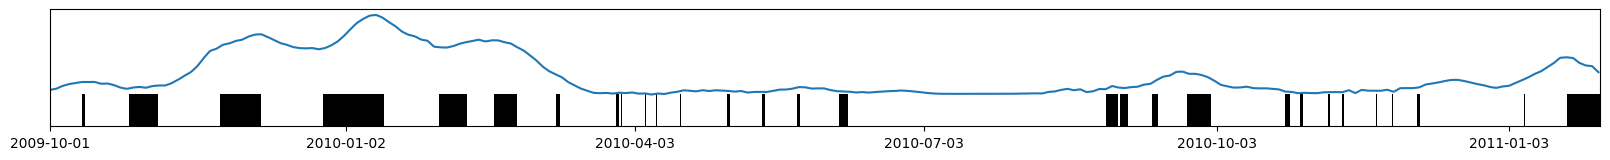

In [9]:
## Example of activation map visualization for breeding vs non breeding 

gradcam_NB_B = Gradcam(model_NB_B,
                  model_modifier=replace2linear,
                  clone=True)

###Example for a succesful breeding
rfid = 'R 0000 0000000046627082'
year = 2009
index_rfid_year = data.loc[(data["rfid"] == rfid) & (data["year"] == year)].index[0]

val = tf.expand_dims(np.array(vector).astype(np.float32), axis=0)
score = CategoricalScore([1])
gradcam_map_NB_B = gradcam_NB_B(score, val, penultimate_layer=-1)

x=[]
for i in(vector):
    x.append(i[0])
start_date = datetime.datetime(year=year, month=10, day=1)
end_date = start_date + timedelta(days=487)
dRange = pd.date_range(start=start_date, end=end_date, freq="12H")

fig, ax = plt.subplots(figsize = (20,10))
ax.imshow([x]*20,cmap='binary',interpolation='none', extent=[0, 975, -20, 0])
xlab = [0,186,368,550,734,918] 
ax.set_xticks(xlab)
ax.set_xticklabels([dRange.date[i] for i in xlab])
ax.axes.get_yaxis().set_visible(False)
ax.plot(gradcam_map_NB_B[0]*50)
# fig.savefig('cyclemap_fail.png', dpi = 300)